<a href="https://colab.research.google.com/github/juliakahan/Advanced-Machine-Learning-course/blob/main/MHN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Modern Hopfield Networks

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
from copy import deepcopy
import torch.nn.functional as F

In [29]:
def load_fashion_mnist(batch_size,norm_factor=1):
    transform = transforms.Compose([transforms.ToTensor()])

    #LOAD fasion mnist

    trainset = torchvision.datasets.FashionMNIST(root='./fashionmnist_data', train=True,
                                                 download=True, transform=transform)
    print("trainset: ", trainset)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True)
    print("trainloader: ", trainloader)
    trainset = list(iter(trainloader))

    testset = torchvision.datasets.FashionMNIST(root='./fashionmnist_data', train=False,
                                                download=True, transform=transform)

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=True)
    testset = list(iter(testloader))
    for i,(img, label) in enumerate(trainset):
        trainset[i] = (img.reshape(len(img),784) /norm_factor ,label)
    for i,(img, label) in enumerate(testset):
        testset[i] = (img.reshape(len(img),784) /norm_factor ,label)
    return trainset, testset

trainset, testset = load_fashion_mnist(1000)


trainset:  Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./fashionmnist_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
trainloader:  <torch.utils.data.dataloader.DataLoader object at 0x7a78de6507f0>


Binarization to 1 and -1 (! not 0)

In [30]:
def binarize(img):
  i = deepcopy(img)
  i[img > 0] = -1
  i[img <=0] = 1
  return i

Initial version

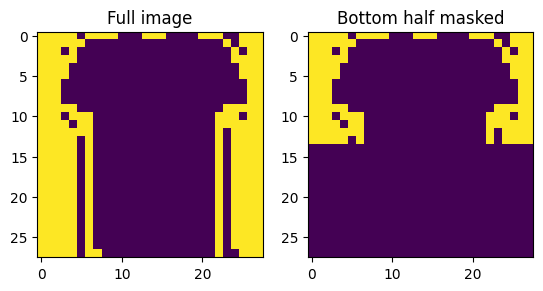

In [31]:
def zero_bottom_half(img):
  i = deepcopy(img)
  H,W = img.shape
  i[H//2:H,:] = -1
  return i

imgs,labels = trainset[0]
digit = imgs[3,:].reshape(784,1)
digit = binarize(digit)
halved_digit = zero_bottom_half(digit.reshape(28,28)).reshape(784,1)
plt.subplot(1,2,1)
plt.title("Full image")
plt.imshow(digit.reshape(28,28))
plt.subplot(1,2,2)
plt.title("Bottom half masked")
plt.imshow(halved_digit.reshape(28,28))
plt.show()

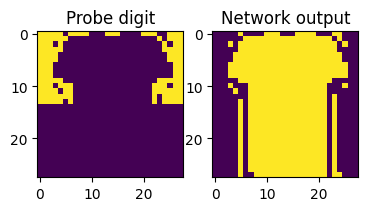

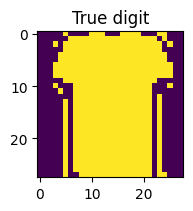

In [32]:
# Store a single digit in the weights
W = digit @ digit.T
# perform the hopfield update rule with the probe as the halved digit to retrieve the original
out = binarize(W @ halved_digit)

#plot
plt.subplot(1,3,1)
plt.title("Probe digit")
plt.imshow(halved_digit.reshape(28,28))
plt.subplot(1,3,2)
plt.title("Network output")
plt.imshow(out.reshape(28,28))
plt.show()
plt.subplot(1,3,3)
plt.title("True digit")
plt.imshow(out.reshape(28,28))
plt.show()

Introduce the following variant of the masking function and play with it (prepare presentation of interesting results):
an option to select which half of the image can be masked (8 half-planes of slicing: / |  - ),
add noise (i.e. random changing value of pixels in the whole image).

In [35]:
trainset, testset = load_fashion_mnist(1000)

trainset:  Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./fashionmnist_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
trainloader:  <torch.utils.data.dataloader.DataLoader object at 0x7a78dea1aad0>


In [38]:
def mask_chosen_part(img, part, noise_level = 0.1):
  i = deepcopy(img)
  H,W = img.shape

  # "---" slicing
  if part == "bottom":
    i[H//2:H,:] = -1
  elif part == "top":
    i[0:H//2,:] = -1

  # "|" slicing
  elif part == "left":
    i[:, 0:W//2] = -1
  elif part == "right":
    i[:, W//2:W] = -1

  # "\" slicing
  elif part == "bottom left":
    for row in range(H):
      for col in range(W):
        if row > col:
          i[row, col] = -1

  elif part == "bottom right":
    for row in range(H):
      for col in range(W):
        if row + col >= W:
            i[row, col] = -1

  elif part == "top right":
    for row in range(H):
      for col in range(W):
        if row < col:
            i[row, col] = -1

    # Fixed "top right" mask
  elif part == "top left":
      for row in range(H):
          for col in range(W):
              if row + col < W:  # Corrected condition
                  i[row, col] = -1

  # add noise (i.e. random changing value of pixels in the whole image)
  noise = torch.rand(H, W)
  noisy_pixels = noise < noise_level
  i[noisy_pixels] = torch.randint(0, 2, size=(noisy_pixels.sum().item(),), dtype=img.dtype)

  return i

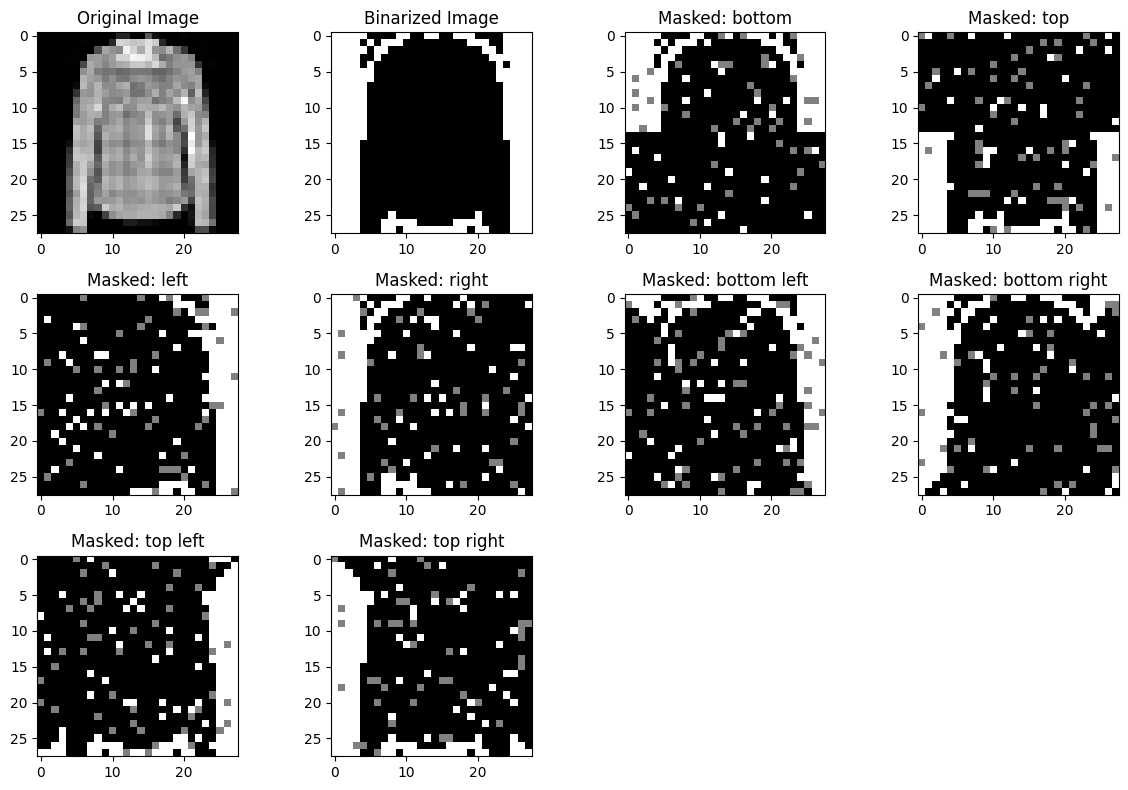

In [39]:
def visualize_masks_with_noise(img, noise_level=0.1):
    digit = img.reshape(28, 28)

    binarized_digit = binarize(digit)

    parts = ["bottom", "top", "left", "right", "bottom left", "bottom right", "top left", "top right"]

    plt.figure(figsize=(12, 8))

    plt.subplot(3, 4, 1)
    plt.title("Original Image")
    plt.imshow(digit, cmap='gray')

    plt.subplot(3, 4, 2)
    plt.title("Binarized Image")
    plt.imshow(binarized_digit, cmap='gray')

    for idx, part in enumerate(parts, 3):
        masked_digit = mask_chosen_part(binarized_digit, part, noise_level=noise_level)
        plt.subplot(3, 4, idx)
        plt.title(f"Masked: {part}")
        plt.imshow(masked_digit, cmap='gray')

    plt.tight_layout()
    plt.show()

imgs, labels = trainset[0]
digit = imgs[3, :].reshape(784, 1)

visualize_masks_with_noise(digit, noise_level=0.1)

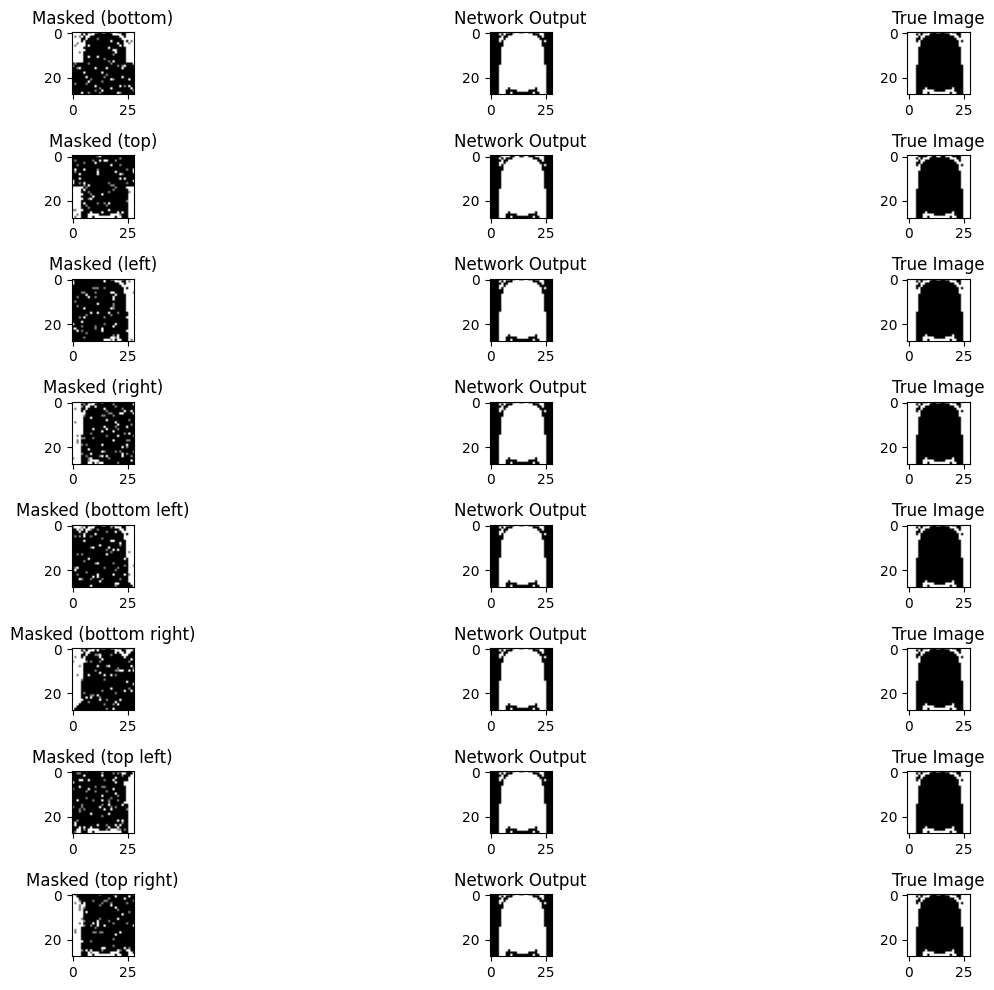

In [40]:
def retrieve_original(digit, masked_digit):
    W = digit @ digit.T

    out = binarize(W @ masked_digit)

    return out

def visualize_retrieval_with_masks(img, noise_level=0.1):
    digit = img.reshape(28, 28)
    binarized_digit = binarize(digit)
    parts = ["bottom", "top", "left", "right", "bottom left", "bottom right", "top left", "top right"]

    plt.figure(figsize=(15, 10))

    for idx, part in enumerate(parts):
        masked_digit = mask_chosen_part(binarized_digit, part, noise_level=noise_level)
        masked_digit_flat = masked_digit.reshape(784, 1)

        retrieved_digit = retrieve_original(binarized_digit.reshape(784, 1), masked_digit_flat)

        plt.subplot(len(parts), 3, idx * 3 + 1)
        plt.title(f"Masked ({part})")
        plt.imshow(masked_digit, cmap='gray')

        plt.subplot(len(parts), 3, idx * 3 + 2)
        plt.title("Network Output")
        plt.imshow(retrieved_digit.reshape(28, 28), cmap='gray')

        plt.subplot(len(parts), 3, idx * 3 + 3)
        plt.title("True Image")
        plt.imshow(binarized_digit, cmap='gray')

    plt.tight_layout()
    plt.show()

imgs, labels = trainset[0]
digit = imgs[3, :].reshape(784, 1)

visualize_retrieval_with_masks(digit, noise_level=0.1)

Testing retrieval capacity when storing multiple images

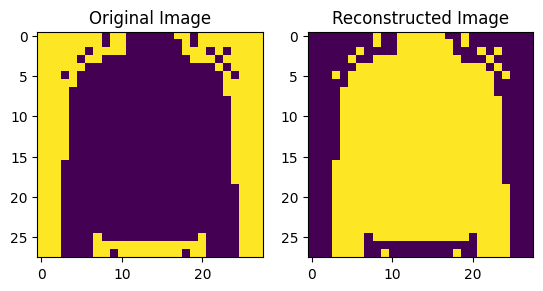

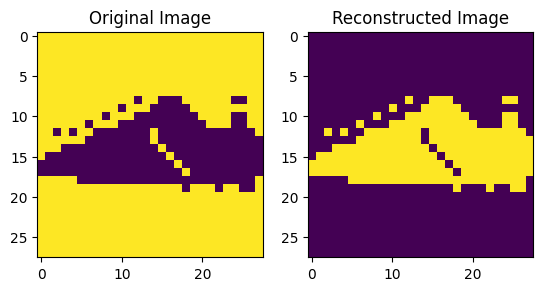

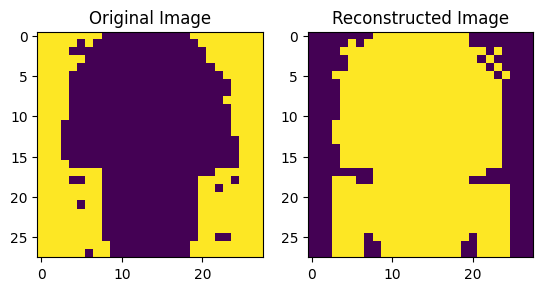

In [41]:
def store_retrieve_N_images(N):
  # construct weight matrix of N stored images
  W = torch.zeros((784,784))
  for i in range(N):
    digit = binarize(imgs[i,:].reshape(784,1))
    W += digit @ digit.T

  # try to retrieve each image
  for i in range(N):
    digit = binarize(imgs[i,:]).reshape(28,28)
    halved_digit = zero_bottom_half(digit).reshape(784,1)
    out = binarize(W @ halved_digit)
    plt.subplot(1,2,1)
    plt.title("Original Image")
    plt.imshow(digit)
    plt.subplot(1,2,2)
    plt.title("Reconstructed Image")
    plt.imshow(out.reshape(28,28))
    plt.show()

store_retrieve_N_images(3)

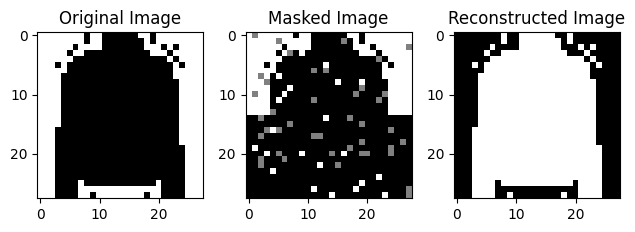

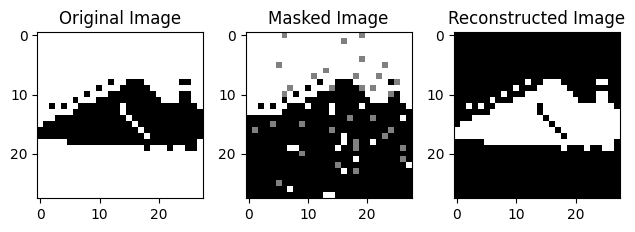

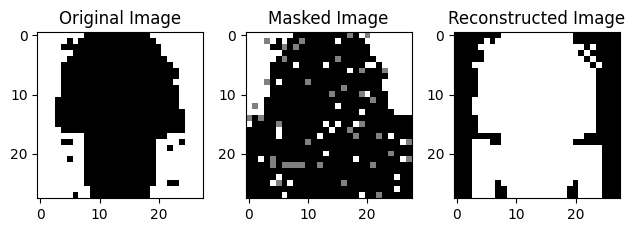

In [42]:
def store_retrieve_N_images(N, part="bottom", noise_level=0.1):
    W = torch.zeros((784, 784))

    for i in range(N):
        digit = binarize(imgs[i, :].reshape(784, 1))
        W += digit @ digit.T

    for i in range(N):
        digit = binarize(imgs[i, :].reshape(28, 28))

        masked_digit = mask_chosen_part(digit, part, noise_level=noise_level).reshape(784, 1)

        out = binarize(W @ masked_digit)

        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(digit, cmap='gray')

        plt.subplot(1, 3, 2)
        plt.title("Masked Image")
        plt.imshow(masked_digit.reshape(28, 28), cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title("Reconstructed Image")
        plt.imshow(out.reshape(28, 28), cmap='gray')

        plt.tight_layout()
        plt.show()

store_retrieve_N_images(3, part="bottom", noise_level=0.1)

Inputs are correlated - let's introduce modern extension

In [43]:
def demircigil_update_rule(z,xs):
  out = torch.zeros(len(z),1)
  # loop over every element of z
  for i in range(len(z)):
    # initialize accumulators for E_positive and E_negative
    E_pos = 0
    E_neg = 0
    # make copies so we don't mutate the original array
    z_pos = deepcopy(z)
    z_neg = deepcopy(z)
    # try both z[l]^+ and z[l]^-
    z_pos[i] = 1
    z_neg[i] = -1
    # for each stored pattern in xs
    for x in xs:
      # compute positive or negative energies
      E_plus = x.T @ z_pos
      E_minus = x.T @ z_neg
      # accumulate their exponents
      E_pos += torch.exp(E_plus/10)
      E_neg += torch.exp(E_minus/10)
    # if energy is greater flip
    if E_pos > E_neg:
      out[i] = 1
    else:
      out[i] = -1
  return out

"Although it works, this update rule isn't great for a number of reasons. Firstly, because we are explicitly comparing permutations of z, it's hard to vectorize, and so is slow. Secondly, a naive implementation is numerically unstable due to exponentiating the energies. This often results in nans or infinities. To get it to work I had to divide the computed energies by an arbitrary constant of 10. However there are probably better ways to do this.

Let's test whether this update rule works with a few stored patterns, thus outperforming the classical Hopfield network on memory storage capacity."

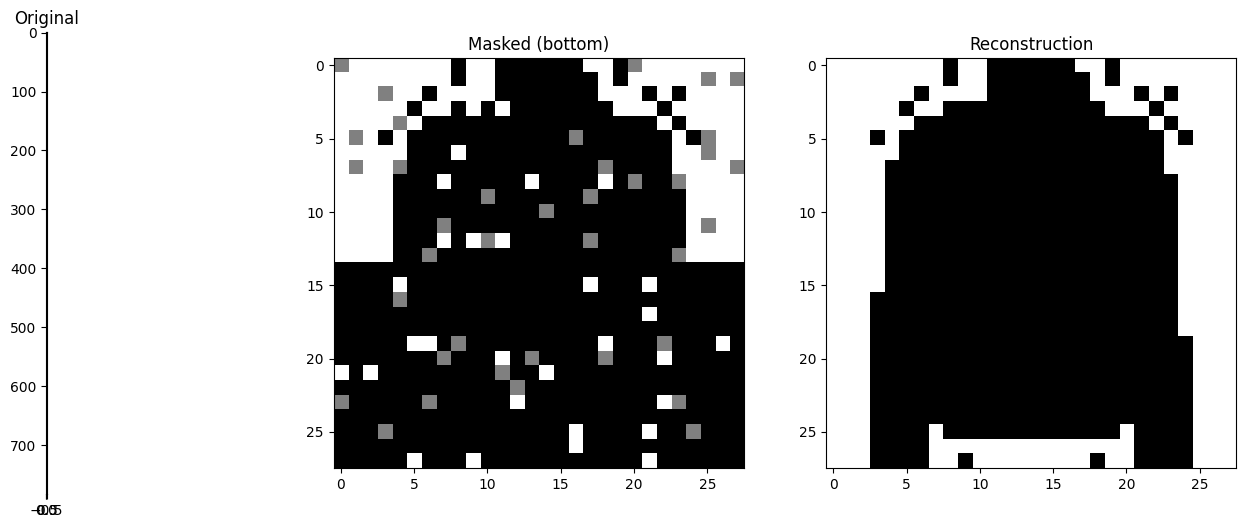

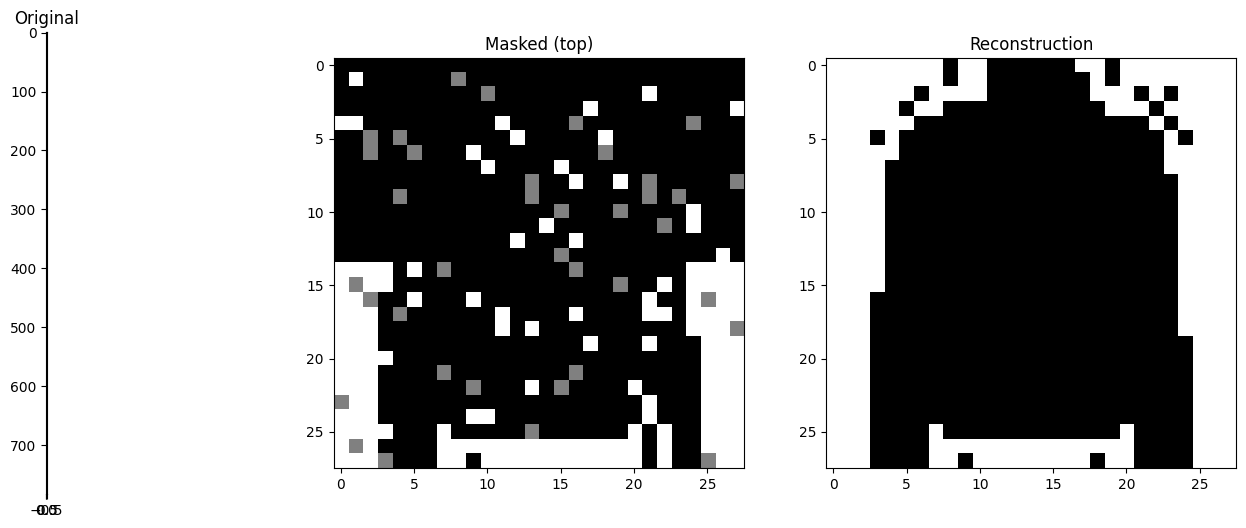

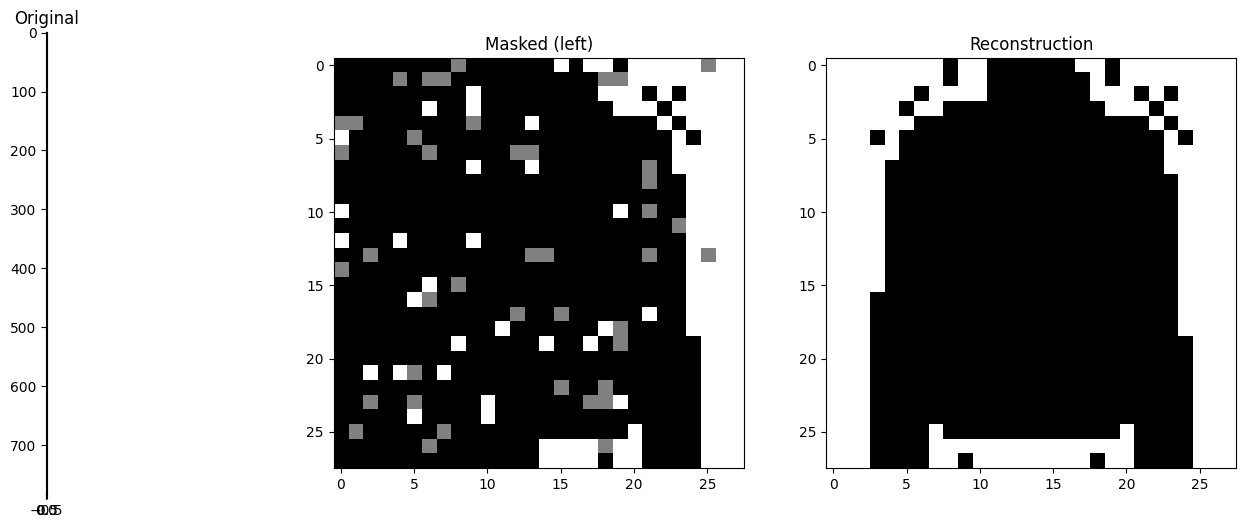

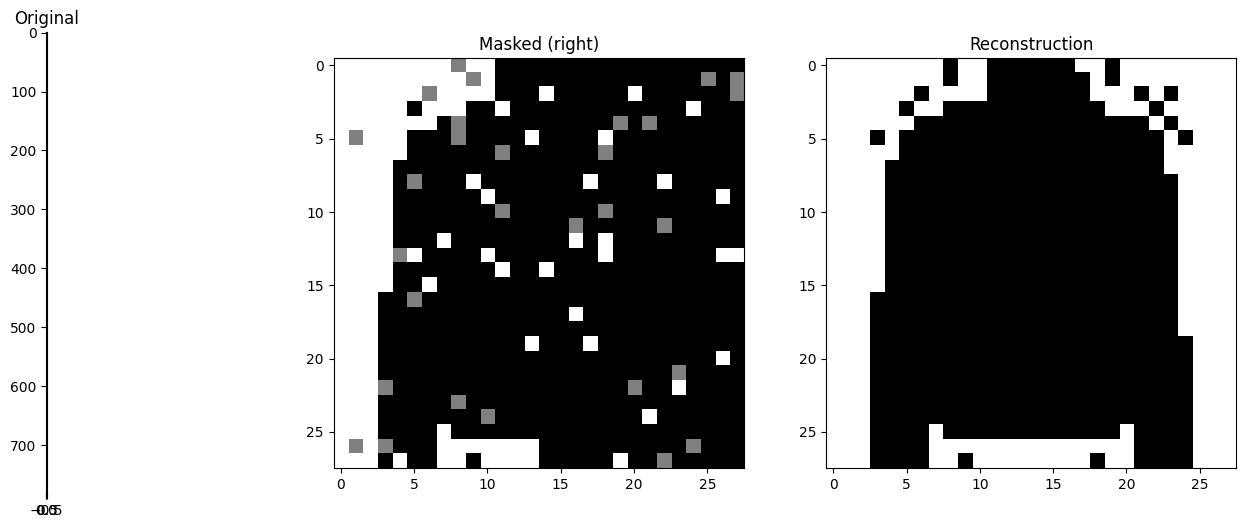

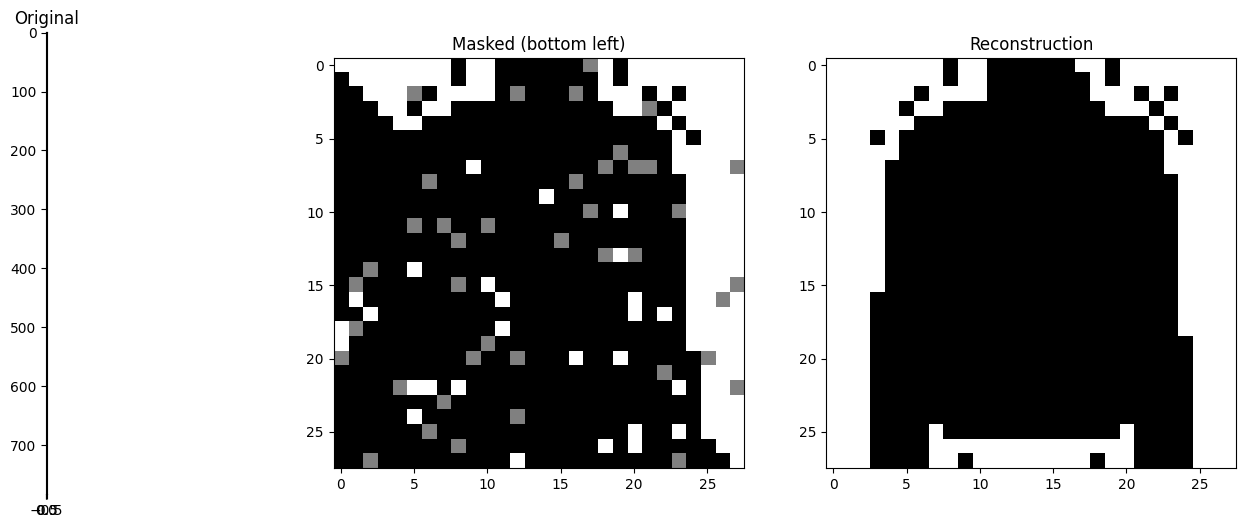

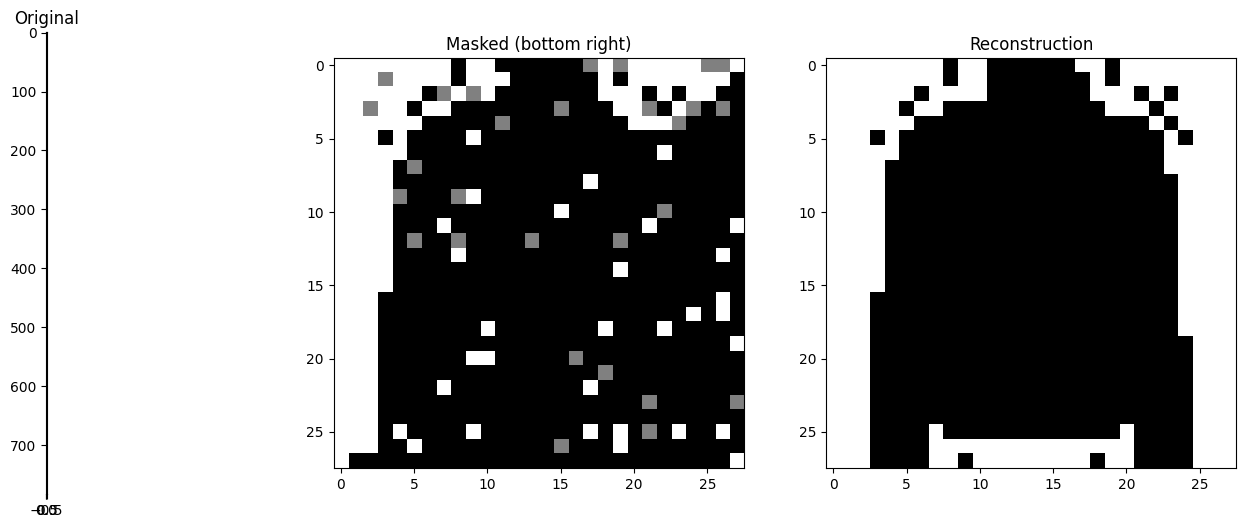

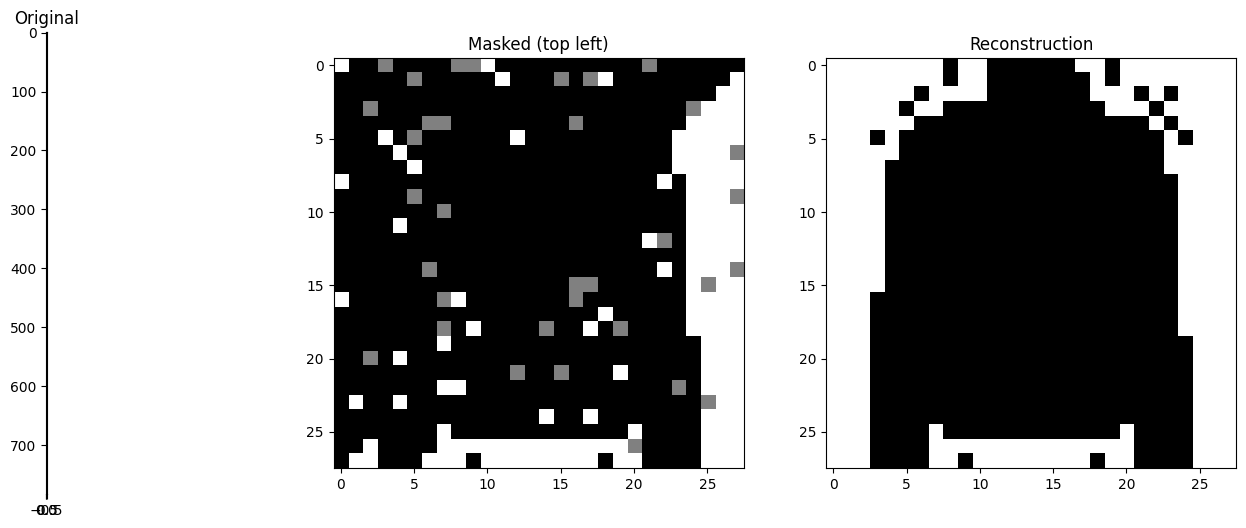

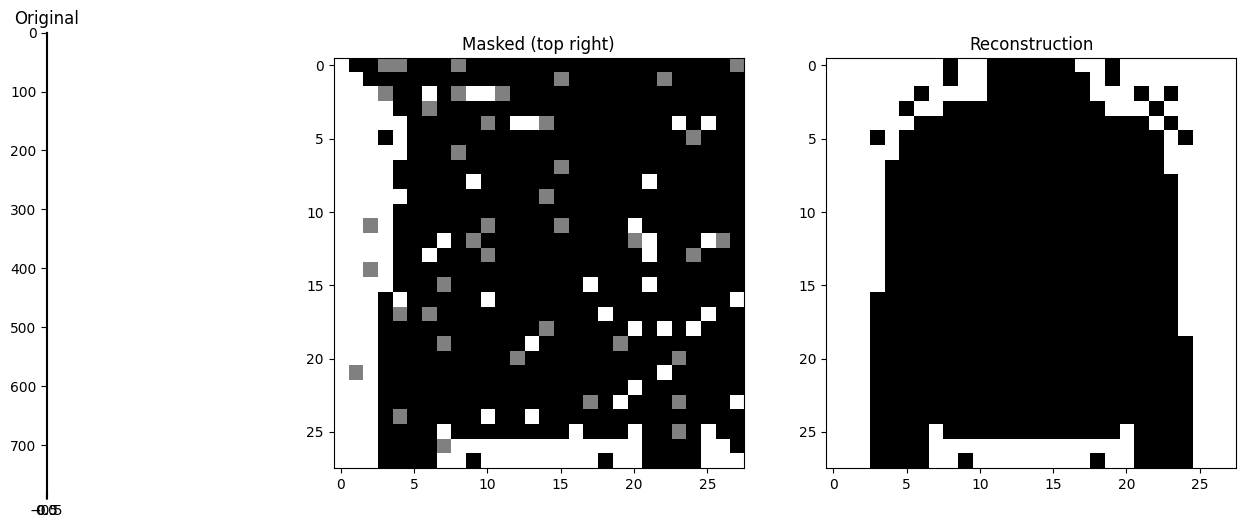

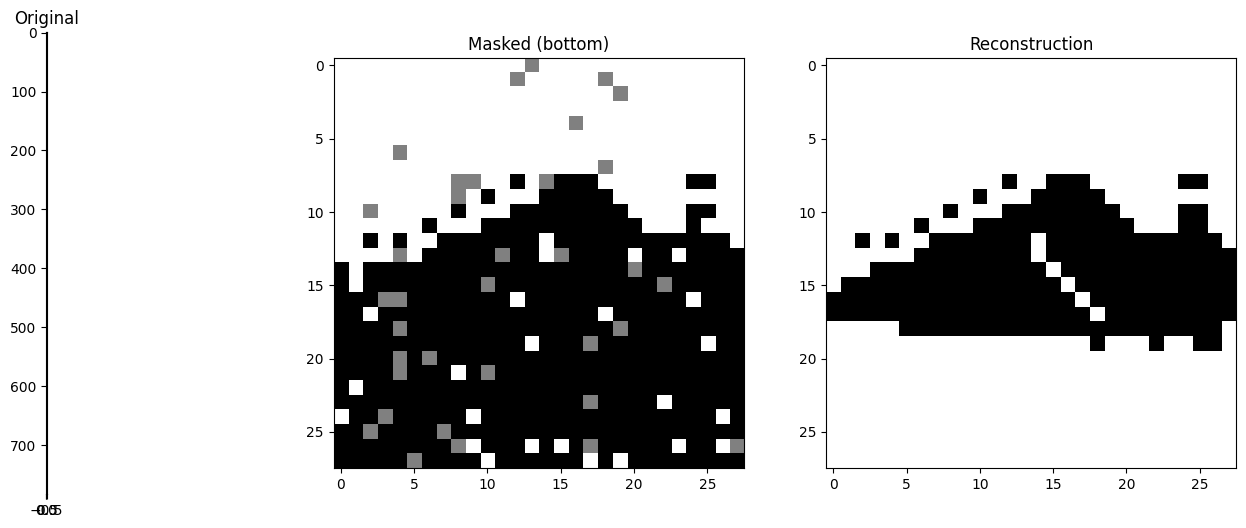

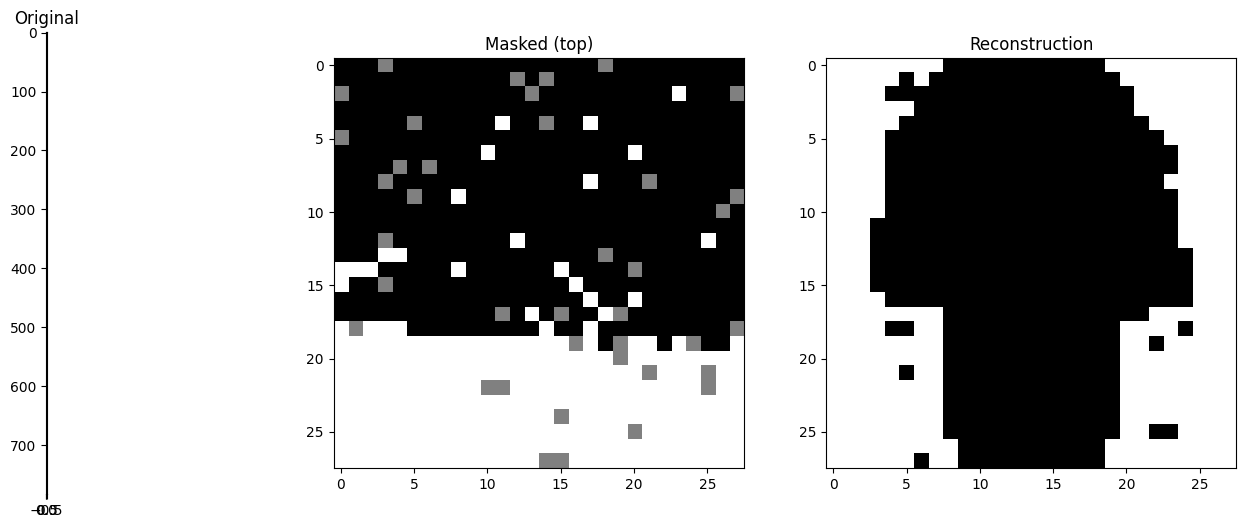

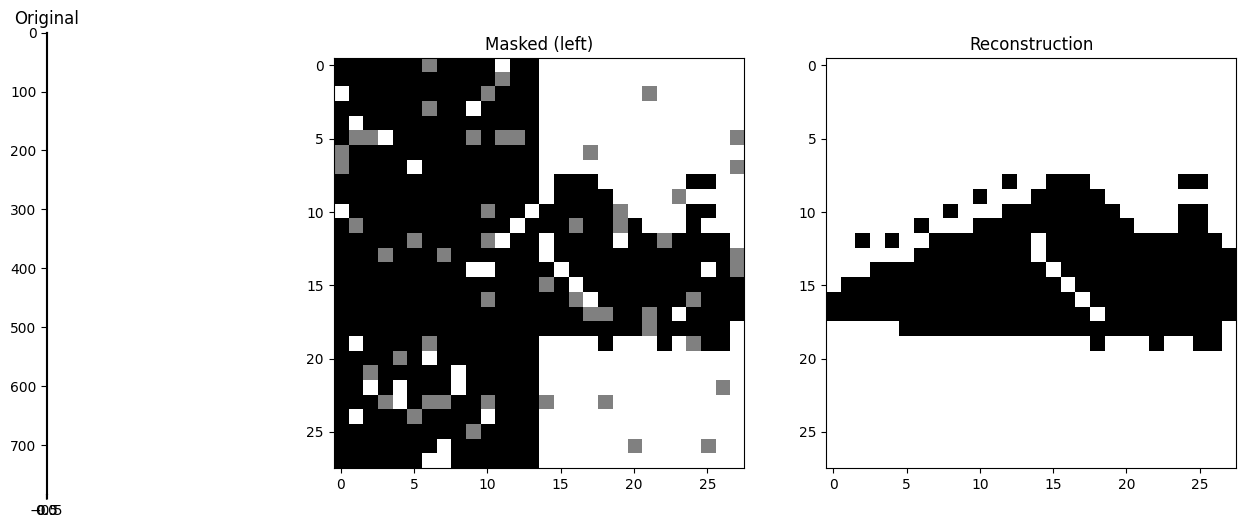

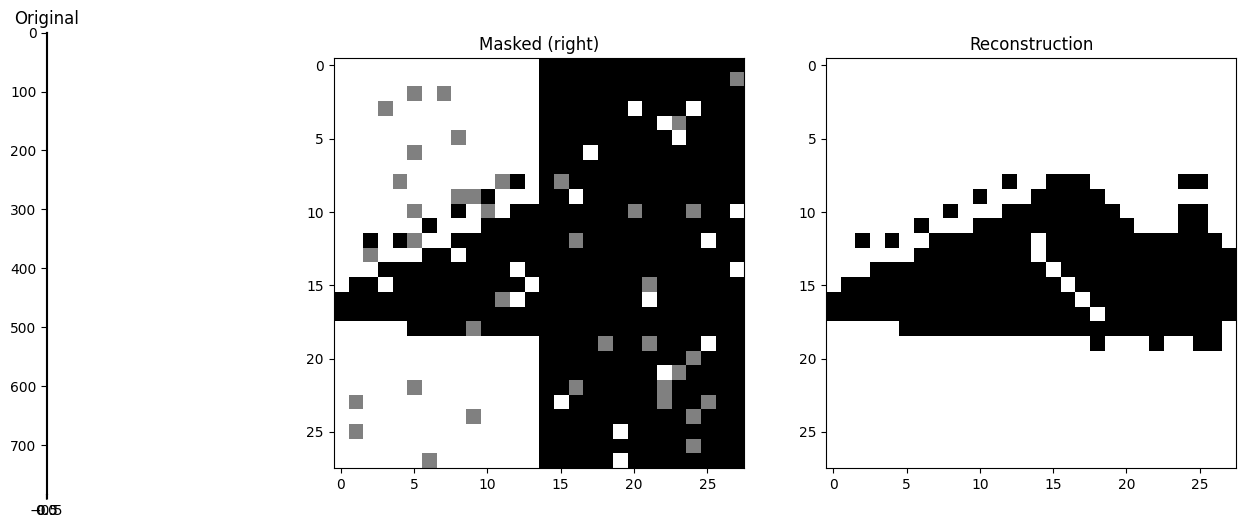

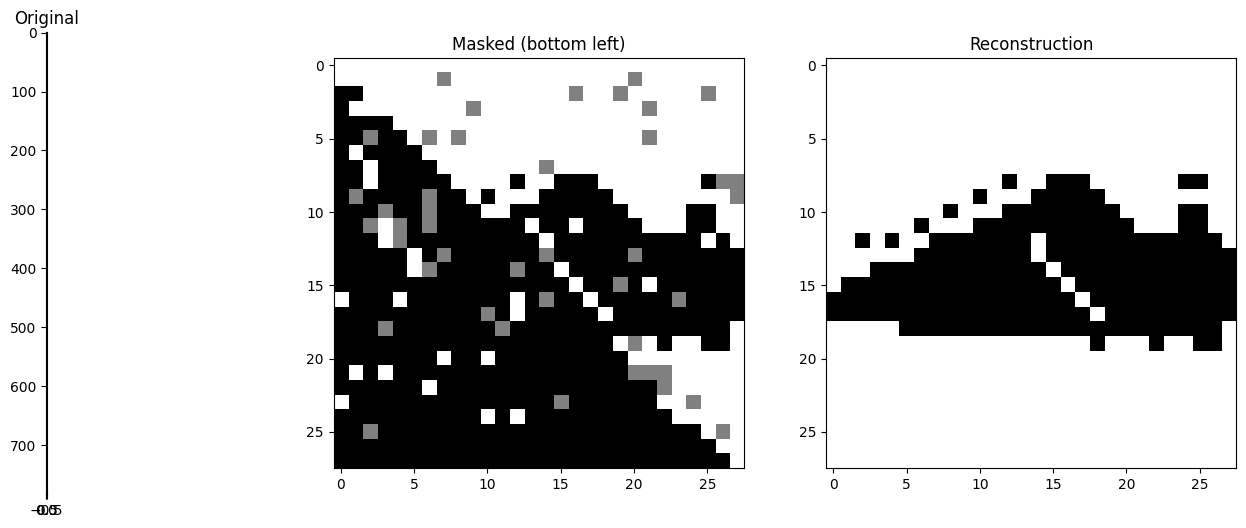

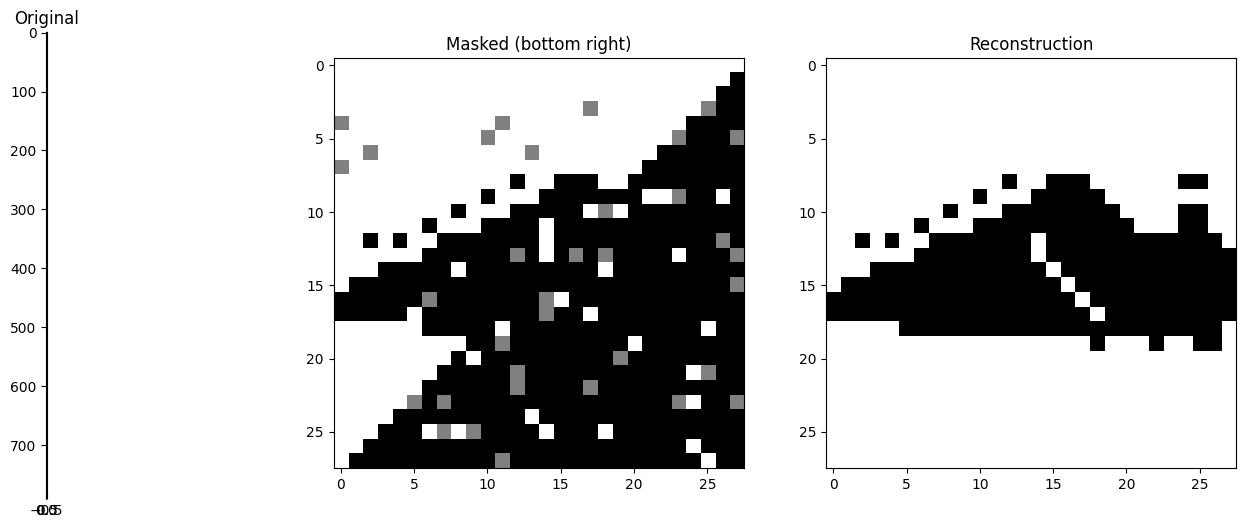

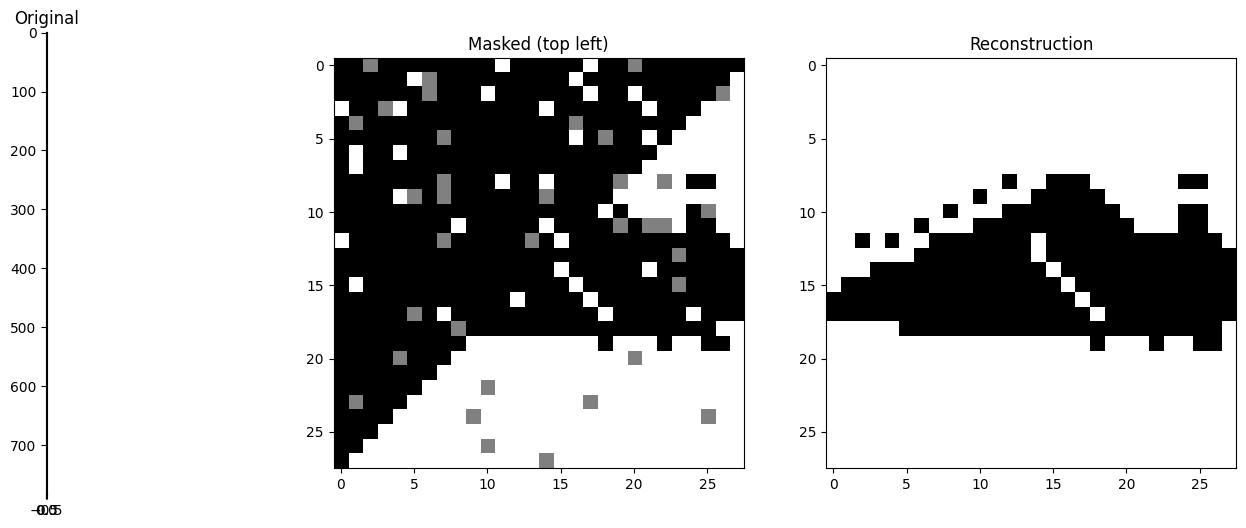

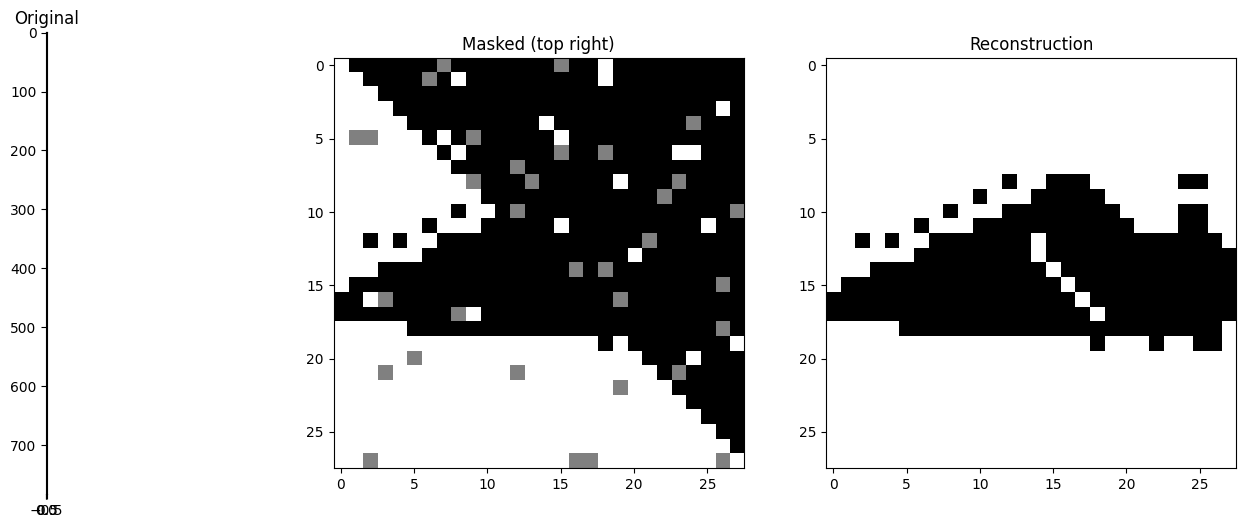

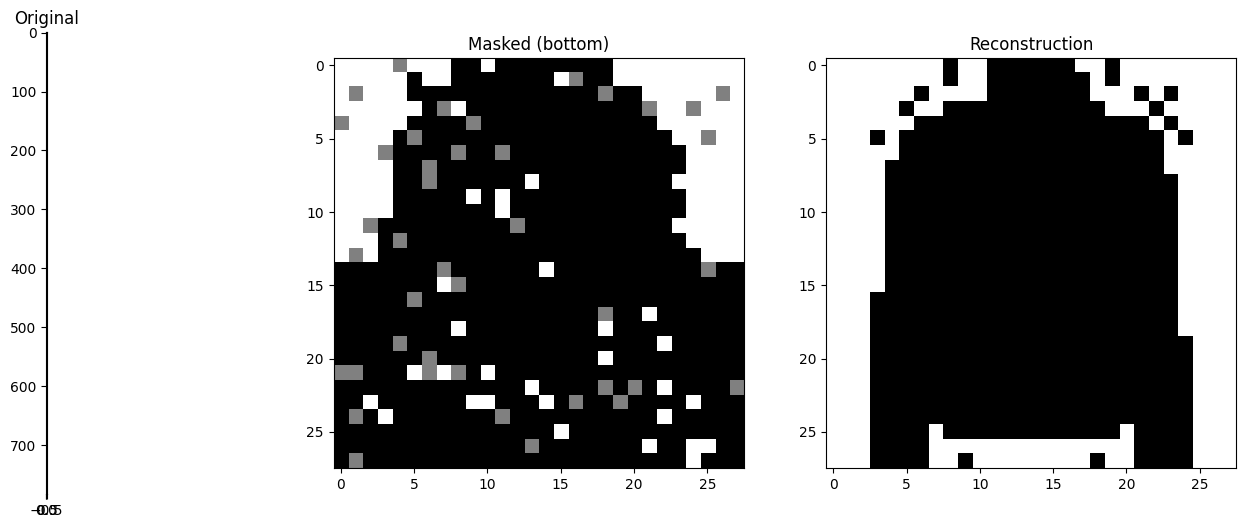

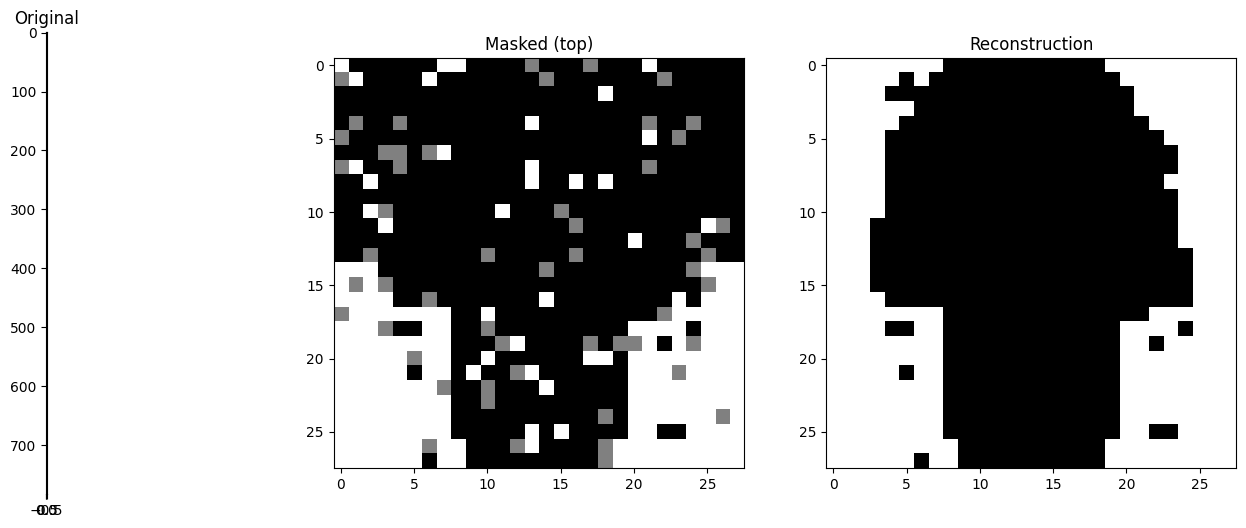

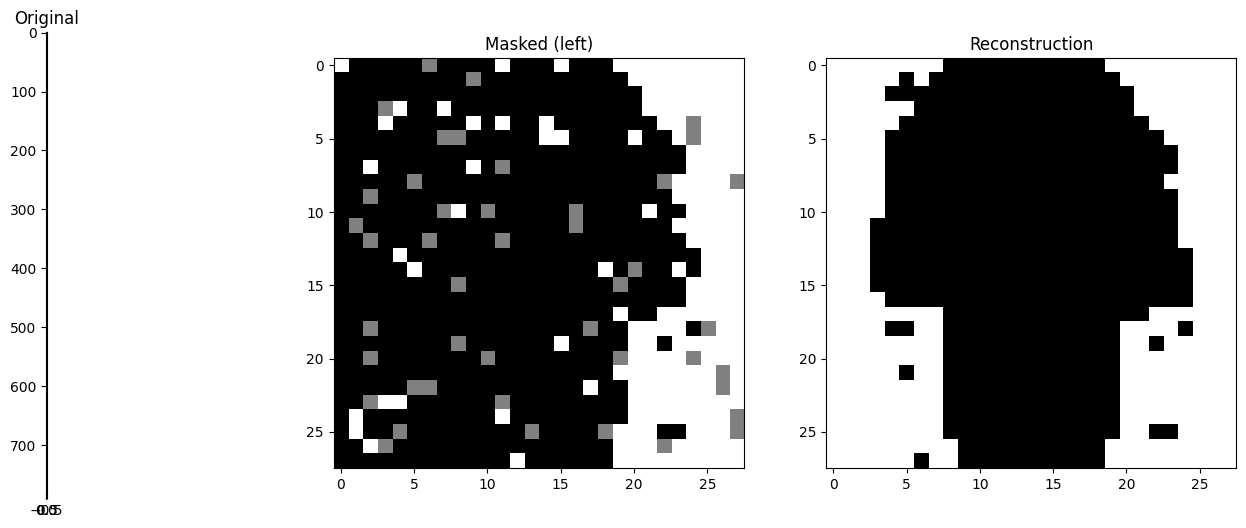

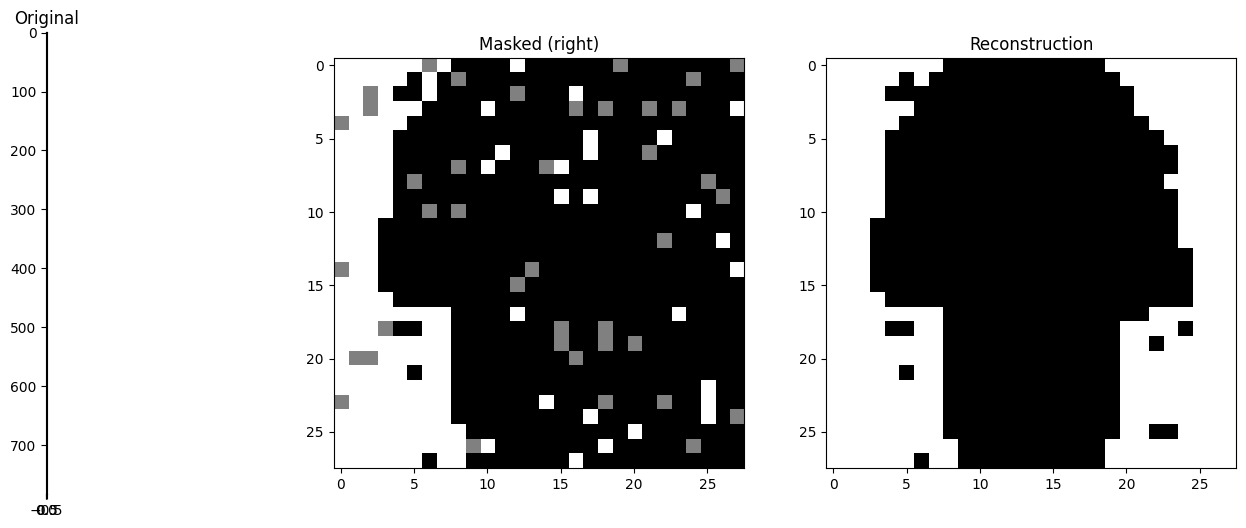

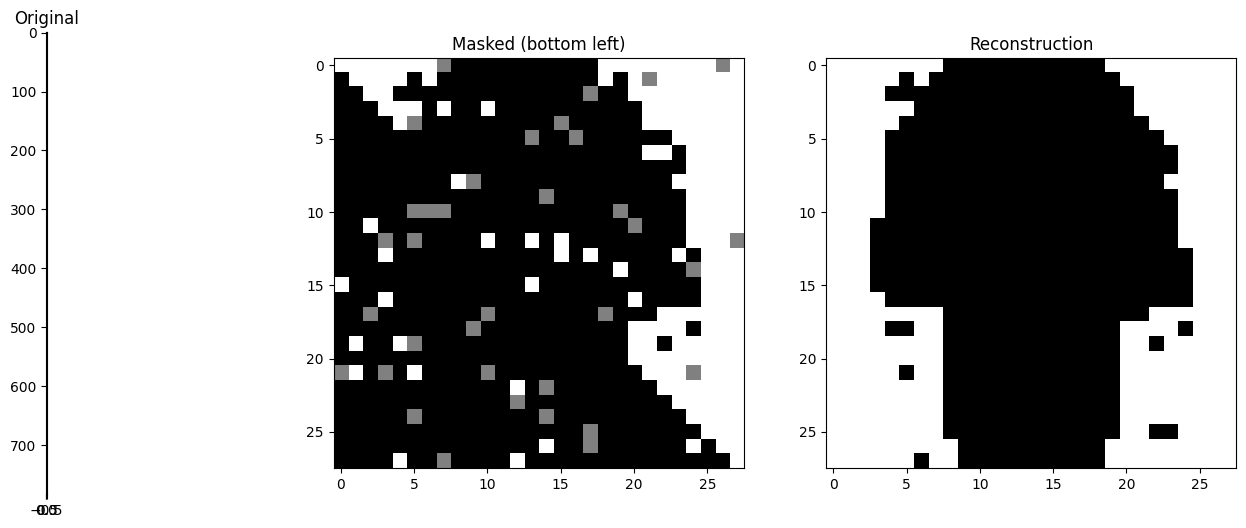

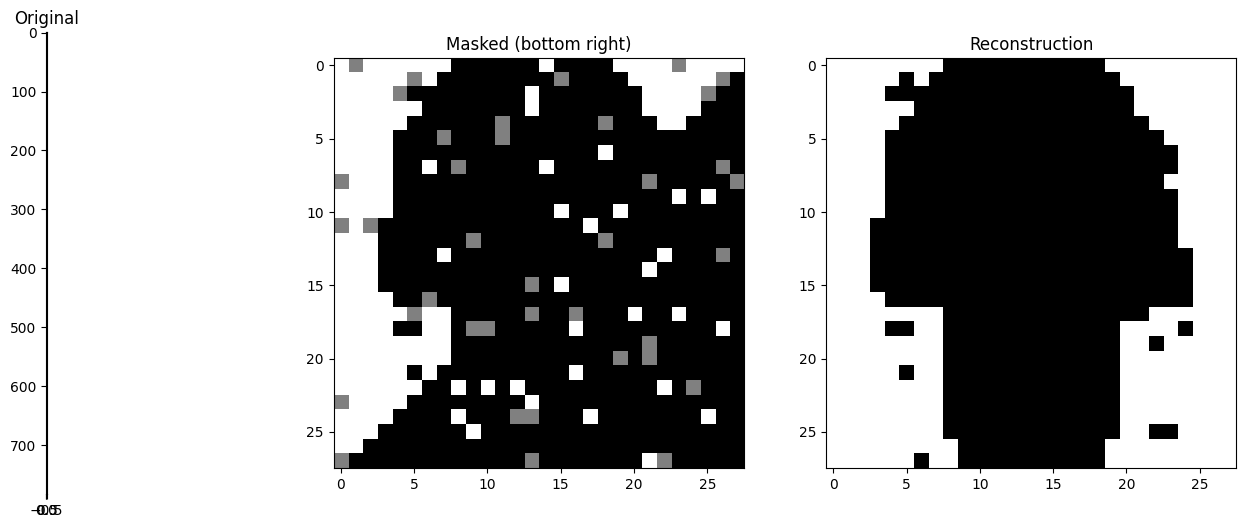

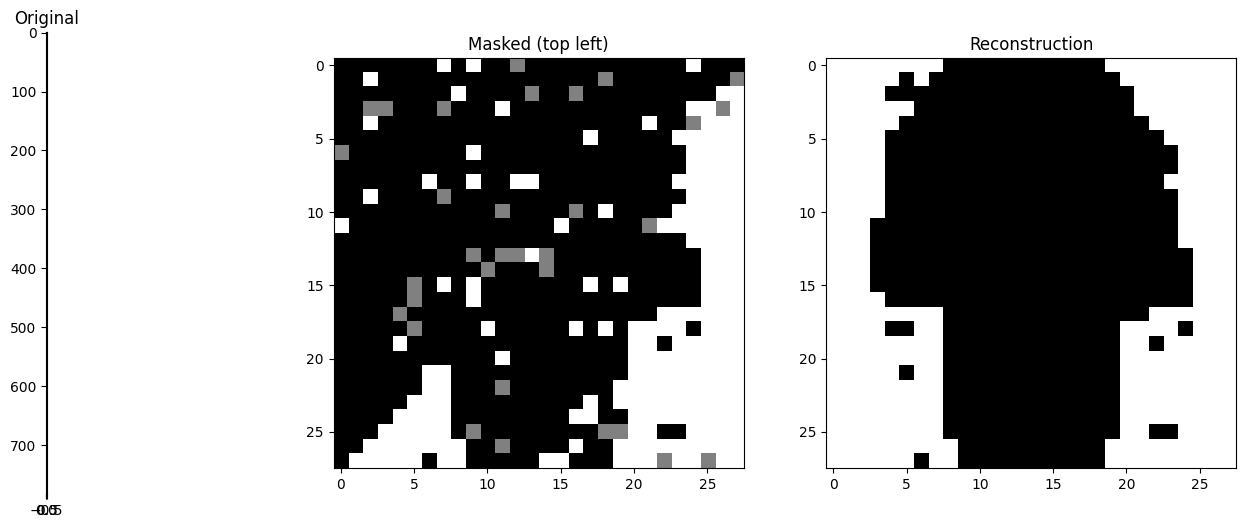

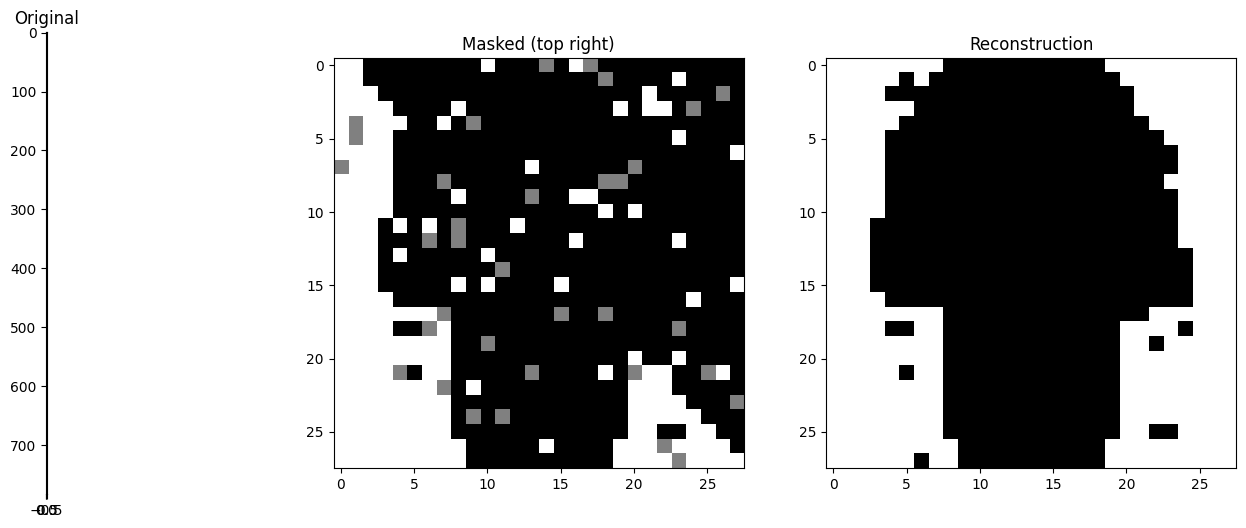

In [45]:
def retrieve_store_demircigil_with_masks(imgs, N, break_val=-1, noise_level=0.1):
    xs = [binarize(imgs[i, :].reshape(784, 1)) for i in range(N)]
    parts = ["bottom", "top", "left", "right", "bottom left", "bottom right", "top left", "top right"]

    for j in range(N):
        if break_val > 0 and j > break_val:
            break

        for part in parts:
            masked_digit = mask_chosen_part(xs[j].reshape(28, 28), part, noise_level).reshape(784, 1)

            out = demircigil_update_rule(masked_digit, xs)

            fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
            imgs_to_show = [xs[j], masked_digit.reshape(28, 28), out.reshape(28, 28)]
            titles = ["Original", "Masked (" + part + ")", "Reconstruction"]

            for i, ax in enumerate(axs.flatten()):
                plt.sca(ax)
                plt.imshow(imgs_to_show[i], cmap='gray')
                plt.title(titles[i])
            plt.show()

retrieve_store_demircigil_with_masks(imgs, N=3, break_val=-1, noise_level=0.1)

# Continuous Modern Hopfield Networks


In [67]:
def mask_chosen_part_continuous(img, part, noise_level=0.1):
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy()

    i = deepcopy(img)
    H, W = img.shape

    if part == "bottom":
        i[H//2:H, :] = 0
    elif part == "top":
        i[0:H//2, :] = 0
    elif part == "left":
        i[:, 0:W//2] = 0
    elif part == "right":
        i[:, W//2:W] = 0
    elif part == "bottom left":
        for row in range(H):
            for col in range(W):
                if row > col:
                    i[row, col] = 0
    elif part == "bottom right":
        for row in range(H):
            for col in range(W):
                if row + col >= W:
                    i[row, col] = 0
    elif part == "top left":
        for row in range(H):
            for col in range(W):
                if row < col:
                    i[row, col] = 0
    elif part == "top right":
        for row in range(H):
            for col in range(W):
                if row + col < W:
                    i[row, col] = 0

    if noise_level is not None:
      noise = np.random.rand(H, W)
      noisy_pixels = noise < noise_level
      i[noisy_pixels] = np.random.rand(noisy_pixels.sum())
    return i


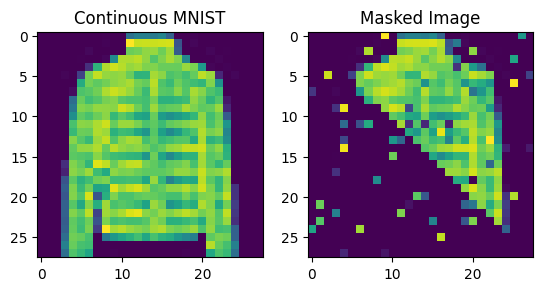

In [70]:
xs = [imgs[i,:] for i in range(100)]
plt.subplot(1,2,1)
plt.imshow(xs[0].reshape(28,28))
plt.title("Continuous MNIST")
halved_img = mask_chosen_part_continuous(xs[0].reshape(28, 28), part = "bottom left", noise_level = 0.1)
plt.subplot(1,2,2)
plt.title("Masked Image")
plt.imshow(halved_img)
plt.show()


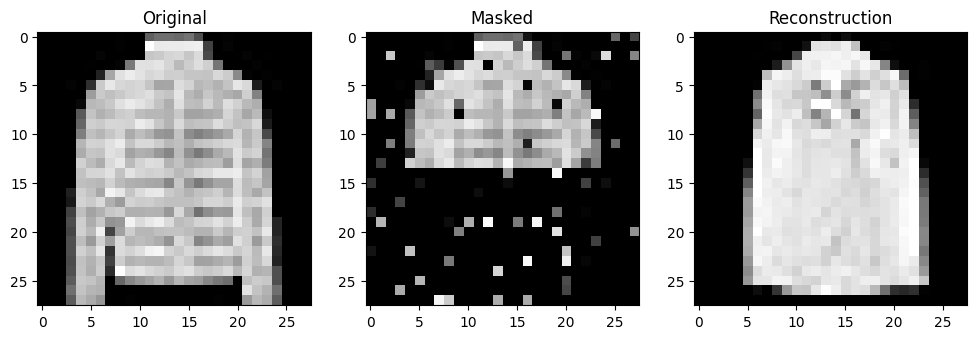

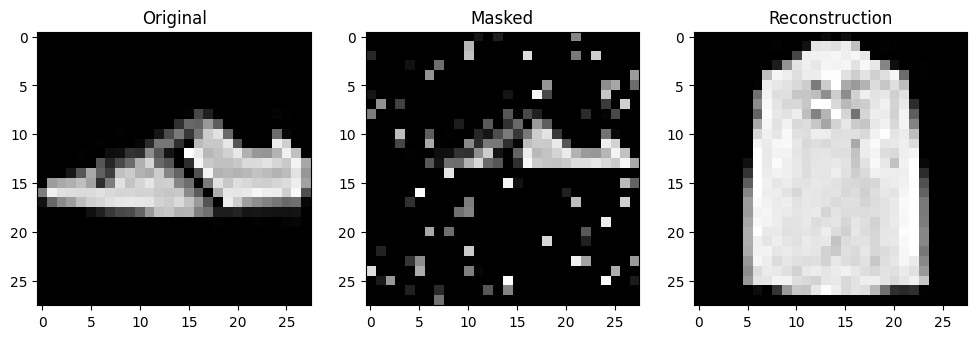

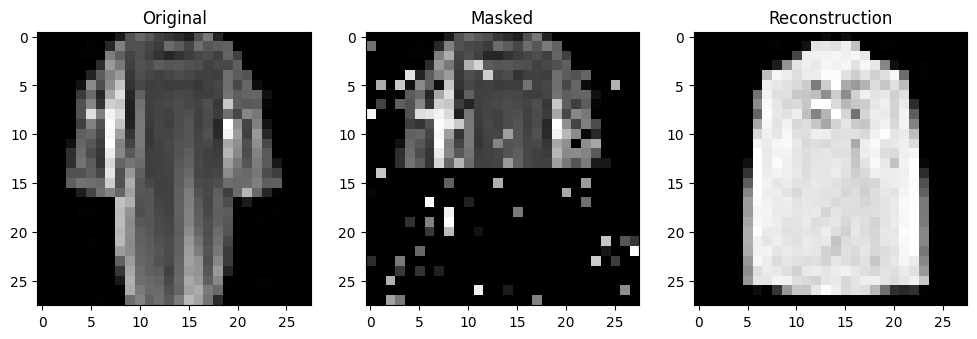

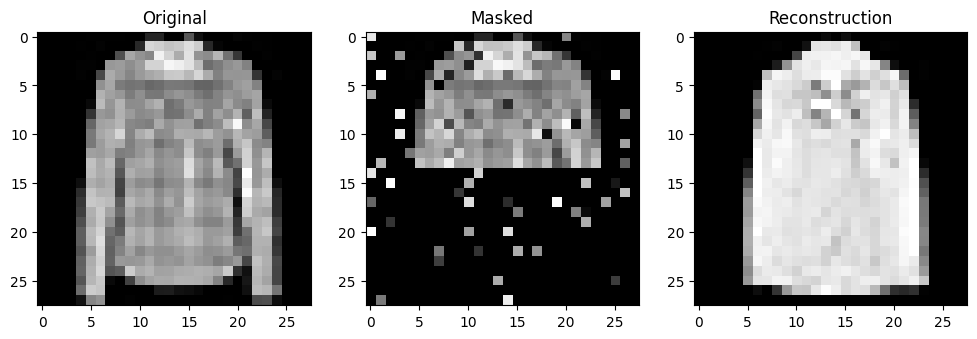

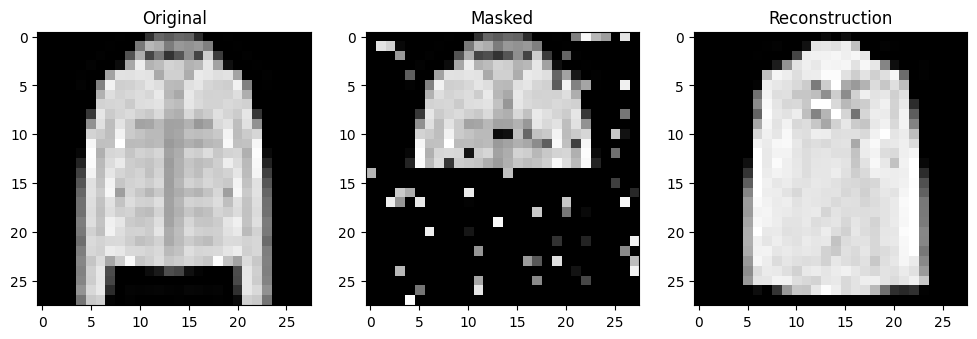

In [72]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Continuous update rule function
def continuous_update_rule(X, z, beta):
    return X.T @ F.softmax(beta * X @ z, dim=0)

# Modified retrieval function using mask_chosen_part_continuous
def retrieve_store_continuous(imgs, N, beta=8, num_plot=5, mask_part="bottom"):
    X = imgs[0:N, :]  # Select the first N images

    for j in range(num_plot):
        # Apply the chosen masking part (using mask_chosen_part_continuous)
        z = mask_chosen_part_continuous(X[j, :].reshape(28, 28), part=mask_part).reshape(784, 1)

        # Perform the continuous update rule
        out = continuous_update_rule(X, z, beta)

        # Plot the original, masked, and reconstructed images
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
        images = [X[j, :], z, out]
        titles = ["Original", "Masked", "Reconstruction"]

        for i, ax in enumerate(axs.flatten()):
            plt.sca(ax)
            plt.imshow(images[i].reshape(28, 28), cmap='gray')
            plt.title(titles[i])

        plt.show()

# Example usage
# Assuming 'imgs' is the dataset with continuous images (normalized or in range [0, 1])
retrieve_store_continuous(imgs, 10, mask_part="bottom")


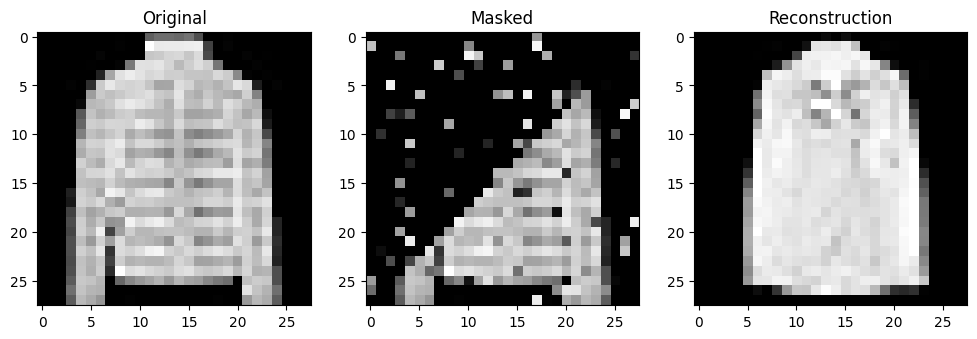

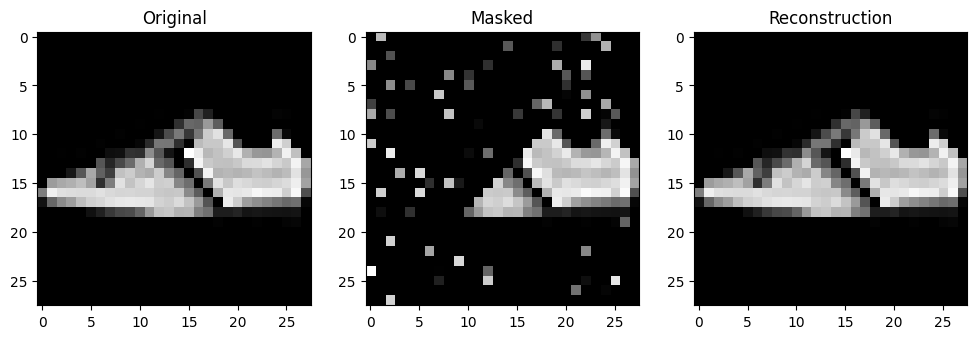

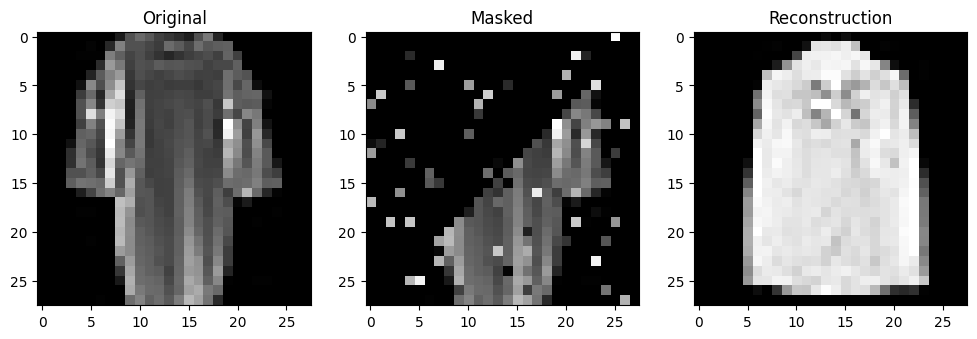

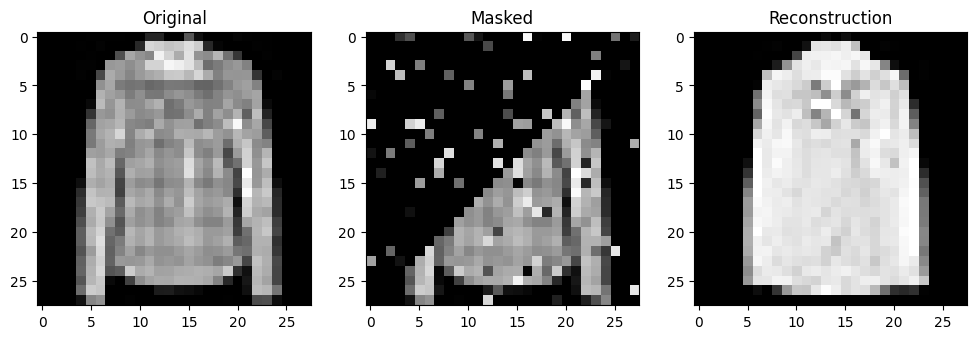

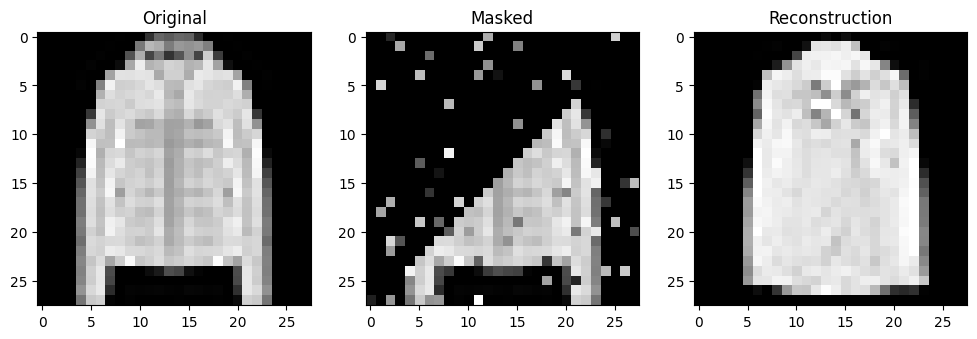

In [73]:
retrieve_store_continuous(imgs, 10, mask_part="top right")


Beta:  0.1


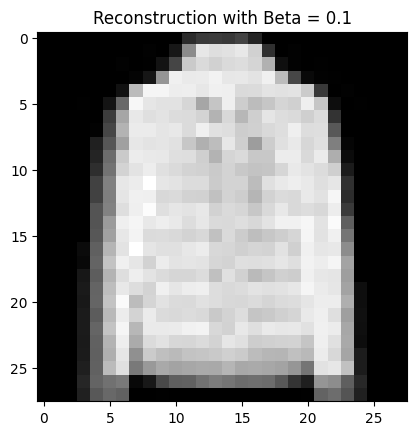

Beta:  0.2


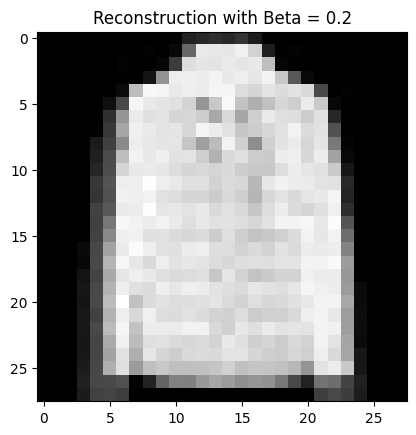

Beta:  0.5


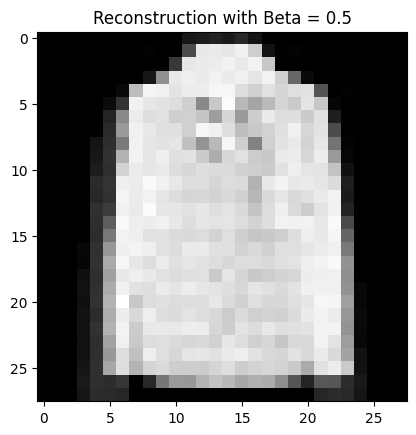

Beta:  1


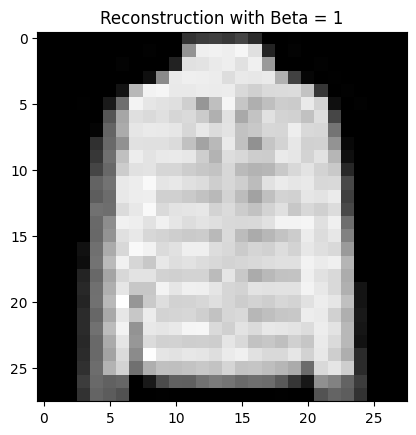

Beta:  2


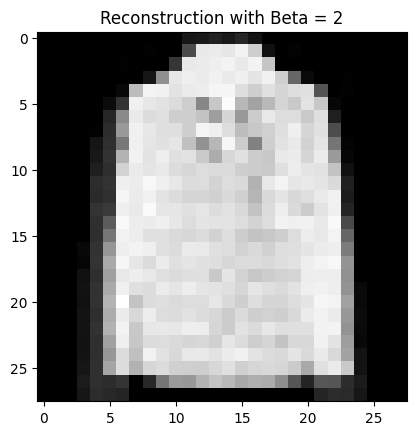

Beta:  4


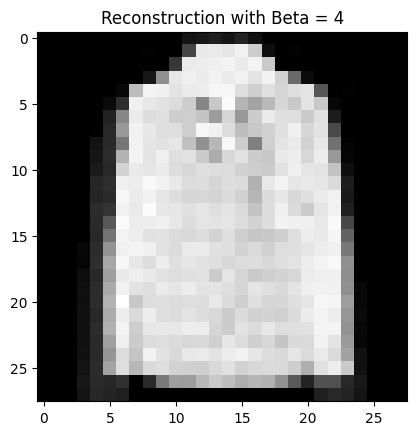

Beta:  8


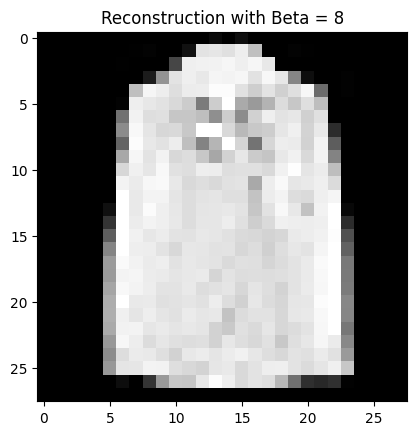

In [76]:
def check_beta_effects(imgs, betas, mask_part="bottom"):
    X = imgs[0:10, :]

    for beta in betas:
        print("Beta: ", beta)

        z = mask_chosen_part_continuous(X[0, :].reshape(28, 28), part=mask_part).reshape(784, 1)

        out = continuous_update_rule(X, z, beta)

        out = out.reshape(28, 28)
        plt.imshow(out, cmap='gray')
        plt.title(f"Reconstruction with Beta = {beta}")
        plt.show()

betas = [0.1, 0.2, 0.5, 1, 2, 4, 8]
check_beta_effects(imgs, betas, mask_part="bottom")